In [1]:
import torch
import copulagp.bvcopula as bvcopula
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [8]:
import pickle as pkl
with open("../started/GLM_generated_data.pkl","rb") as f:
    data = pkl.load(f)

In [10]:
# First, use fastKDE to transform the marginals
import copulagp.marginal as mg
y = torch.zeros(data['Y'].shape)
for i in range(2):
    y[i] = torch.tensor(mg.fast_signal2uniform(data['Y'][i],data['X']))

In [4]:
data['Y']

array([[4.63828008, 3.61137686, 2.81254313, ..., 6.11661203, 5.76312723,
        5.48790371],
       [4.00316099, 3.1175942 , 2.4279848 , ..., 1.52863326, 1.19046542,
        0.92695862]])

In [5]:
# p_perturb = np.random.rand(2)
# up_down = np.random.randint(low=0,high=2,size=2)
# eps = 0.1
# print(up_down)
# for i, (p,up) in enumerate(zip(p_perturb,up_down)):
#     if up:
#         y[i][y[i]>p] = (y[i][y[i]>p] - p) * (1-p-eps)/(1-p) + p + eps
#     else:
#         y[i][y[i]<p] = p - eps - (p - y[i][y[i]<p]) * (p-eps)/p
# plt.hist(y)

In [6]:
# Next, let us try a Clayton copula model on this data (optionally: on a GPU)
device=torch.device('cpu')
train_x = torch.tensor(data['X']).float().to(device=device)
train_y = y.T.float().to(device=device)

likelihoods = [bvcopula.ClaytonCopula_Likelihood(rotation='90°')]
%time 
(waic, model) = bvcopula.infer(likelihoods,train_x,train_y, device=device, prior_rbf_length=2.0)
print(f"WAIC: {waic}")

test_x = torch.linspace(0,1,100).float().to()
model.gp_model.eval()
theta_true = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy() #thetas

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
WAIC: -0.11872898042201996


In [8]:
N_repeats = 20
epsilons = [0.01,0.02,0.05,0.1,0.2,0.5]
theta = np.empty((len(epsilons),N_repeats,100))
perturbs = np.empty((len(epsilons),N_repeats,2))
MSE = np.empty((len(epsilons),N_repeats))
for j,eps in enumerate(epsilons):
    for repeat in tqdm(range(N_repeats)):
        yp = y.clone()
        p_perturb = np.random.rand(2)
        perturbs[j,repeat] = p_perturb
        up_down = np.random.randint(low=0,high=2,size=2)
        for i, (p,up) in enumerate(zip(p_perturb,up_down)):
            if up:
                yp[i][yp[i]>p] = (yp[i][yp[i]>p] - p) * (1-p-eps)/(1-p) + p + eps
            else:
                yp[i][yp[i]<p] = p - eps - (p - yp[i][yp[i]<p]) * (p-eps)/p

        train_y = yp.T.float().to(device=device)

        (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,device=device, prior_rbf_length=2.0)

        test_x = torch.linspace(0,1,100).float().to(device=device)
        model.gp_model.eval()
        theta[j,repeat] = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy() #thetas
    MSE[j] = np.mean((theta[j]-theta_true)**2,axis=-1)
# plt.plot(theta.T)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

0.7913945648971024
0.8352441522327887
0.8971633480210648
0.5137095986224429
0.6500755480394109
0.6247546858595991
0.7682836307117853
0.7003315956207395
0.0707872435432817
0.9676298123270941
0.23992001193172596
0.9576372621181983
0.9646741955629019
0.9764723192684264
0.591030245696565
0.2400628410051152
0.7631726962229074
0.6519652634146984
0.7621657332524346
0.5651187862674437


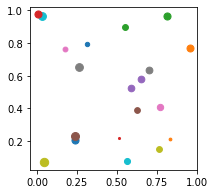

In [ ]:
plt.figure(figsize=(3,3))
for mse, p in zip(MSE[-2],perturbs[-2]):
    print(np.max(p))
    plt.scatter(*p,s=(np.log(mse)+10)**2)

array([0.00039121, 0.00042483, 0.00815813, 0.01936802, 0.04856408,
       0.17089804])

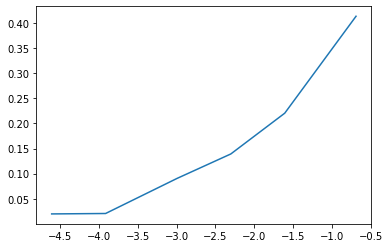

In [ ]:
plt.plot(np.log(epsilons),np.sqrt(MSE.mean(1)))
MSE.mean(1)

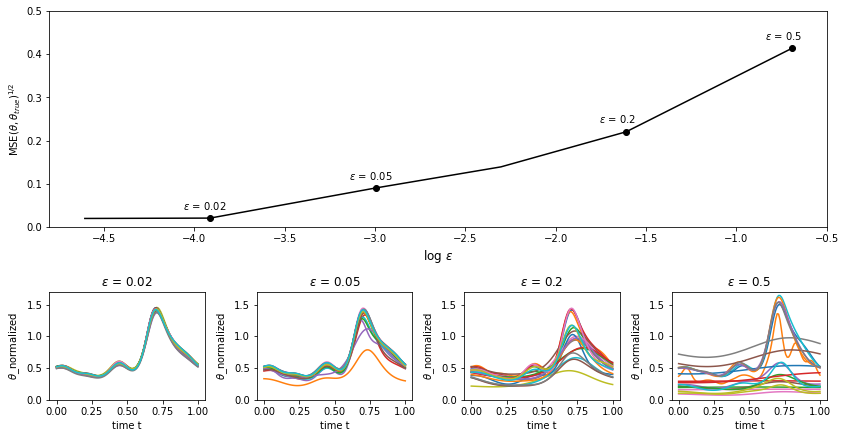

In [ ]:
fig = plt.figure(figsize=(12,6))
# fig.add_axes([0,0,1,1])
ax_plot = fig.add_axes([0.05,0.5,0.9,0.5])
ax_plot.plot(np.log(epsilons),np.sqrt(MSE.mean(1)),c='k')
ax_plot.set_ylim([0,0.5])
ax_plot.set_xlabel(r"log $\epsilon$",fontsize=12)
ax_plot.set_ylabel(r'MSE$(\theta,\theta_{true})^{1/2}$')
axes = [fig.add_axes([0.05,0.1,0.18,0.25]),
       fig.add_axes([0.29,0.1,0.18,0.25]),
       fig.add_axes([0.53,0.1,0.18,0.25]),
       fig.add_axes([0.77,0.1,0.18,0.25])]
for i,ax in zip([1,2,4,5],axes):
    ax.set_ylim([0,1.7])
    ax.set_xlabel('time t')
    ax.set_ylabel(r'$\theta$_normalized')
    ax.plot(np.linspace(0,1,100),theta[i].T)
    ax.set_title(rf'$\epsilon$ = {epsilons[i]}')
    
    ax_plot.scatter(np.log(epsilons[i]),np.sqrt(MSE.mean(1))[i],c='k')
    ax_plot.text(np.log(epsilons[i])-0.15,np.sqrt(MSE.mean(1))[i]+0.02,rf'$\epsilon$ = {epsilons[i]}')
    

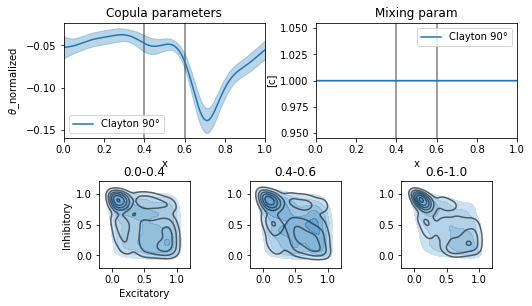

In [ ]:
# let us plot the results
from copulagp.utils import Plot_Fit
clayton = Plot_Fit(model, data['X'], y.numpy().T,'Excitatory', 'Inhibitory', device);
clayton.savefig("started/clayton.png")

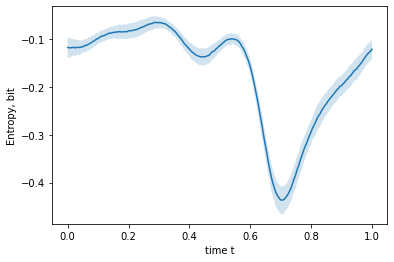

In [ ]:
# calculate entropy on this model (=mutual information between variables)
import matplotlib.pyplot as plt
test_x = torch.linspace(0,1,200).float().to(device=device)
entropies = torch.zeros(50,200)
for i in range(50): 
    f = model.gp_model(test_x).rsample(torch.Size([1])) # sample from a GP
    copula = model.likelihood.get_copula(f) # initialize a copula, parameterized by that GP sample
    entropies[i] = copula.entropy(sem_tol=0.01, mc_size=1000).cpu() # calculate entropy
entropies = entropies.numpy()

plt.plot(test_x.cpu().numpy(),entropies.mean(0))
plt.fill_between(test_x.cpu().numpy(),entropies.mean(0)-entropies.std(0),entropies.mean(0)+entropies.std(0),alpha=0.2)
plt.ylabel('Entropy, bit')
plt.xlabel('time t')
plt.savefig("started/clayton_entropy.png")

In [ ]:
# Clayton copula was a reasonable, but not the optimal choice for the given data. Let us select a better model.
import copulagp.select_copula as select_copula

%time (store, waic) = select_copula.select_with_heuristics(data['X'],y.numpy().T,device,'cond',\
                                            './','Excitatory','Inhibitory',train_x=train_x,train_y=train_y)
print(f"Best model: {store.name_string}, WAIC: {waic}")
with open("started/GLM_best_model.pkl","wb") as f:
    pkl.dump(store,f)

In [4]:
import pickle as pkl
# if selection takes too long (normally 8 min), load a pre-computed serialized model
with open("../started/GLM_best_model.pkl","rb") as f:
    store = pkl.load(f)

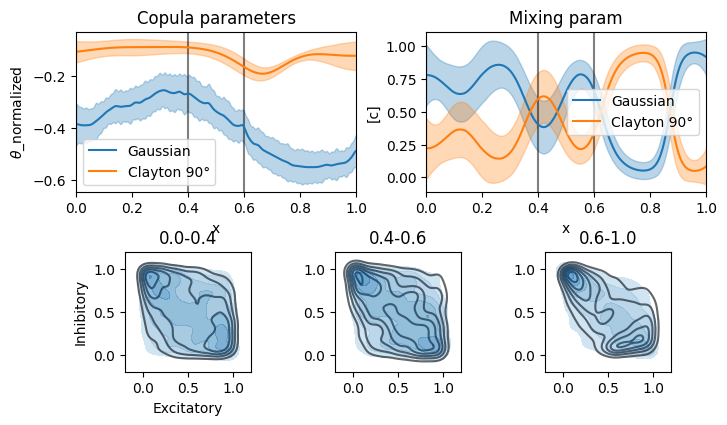

In [12]:
device='cpu'
from copulagp.utils import Plot_Fit
best_model = store.model_init(device)
best = Plot_Fit(best_model, data['X'], y.numpy().T,'Excitatory', 'Inhibitory', device);
best.savefig("../started/best_model.png")

100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'started/entropy_comparison.png'

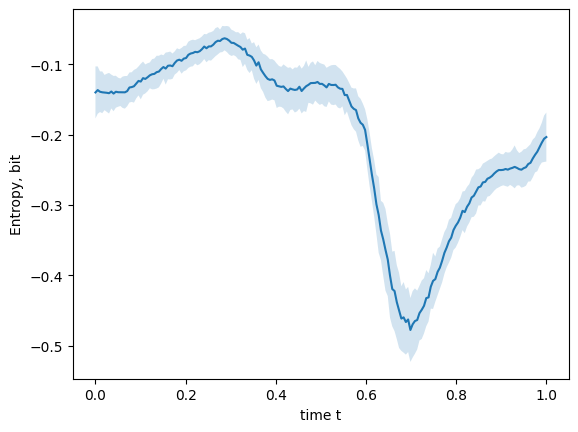

In [17]:
# compare entropies 
from tqdm import tqdm
test_x = torch.linspace(0,1,200).float().to(device=device)
best_entropies = torch.zeros(50,200)
mc_size = 1000
for i in tqdm(range(50)): 
    f = best_model.gp_model(test_x).rsample(torch.Size([1]))
    copula = best_model.likelihood.get_copula(f.squeeze()) 
    best_entropies[i] = copula.entropy(sem_tol=0.01, mc_size=mc_size).cpu()
best_entropies = best_entropies.numpy()

'''plt.plot(test_x.cpu().numpy(),best_entropies.mean(0),label='Clayton')
plt.fill_between(test_x.cpu().numpy(),entropies.mean(0)-entropies.std(0),entropies.mean(0)+entropies.std(0),alpha=0.2)'''
plt.plot(test_x.cpu().numpy(),best_entropies.mean(0),label='Copula mixture')
plt.fill_between(test_x.cpu().numpy(),best_entropies.mean(0)-best_entropies.std(0),best_entropies.mean(0)+best_entropies.std(0),alpha=0.2)
plt.ylabel('Entropy, bit')
plt.xlabel('time t')
plt.savefig("started/entropy_comparison.png")